In [33]:
import pandas as pd

# Load and preprocess data
user_ratings = pd.read_csv('../data/raw/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv('../data/raw/u.item', sep='|', encoding='ISO-8859-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDB_URL', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17', 'genre_18', 'genre_19'])
users = pd.read_csv('../data/raw/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
genres = pd.read_csv('../data/raw/u.genre', sep='|')

## 1. Data Overview and Cleaning

In [34]:
user_ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [35]:
#delete columns that serve no purpose
movies = movies.drop(['video_release_date', 'IMDB_URL'], axis=1)

In [36]:
users.head() 

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [37]:
print(genres)

        unknown   0
0        Action   1
1     Adventure   2
2     Animation   3
3    Children's   4
4        Comedy   5
5         Crime   6
6   Documentary   7
7         Drama   8
8       Fantasy   9
9     Film-Noir  10
10       Horror  11
11      Musical  12
12      Mystery  13
13      Romance  14
14       Sci-Fi  15
15     Thriller  16
16          War  17
17      Western  18


Detailed genre names from u.genre are not included, simplifying data processing and avoiding potential inaccuracies without significantly reducing the model's effectiveness or insights.

In [38]:
# delete date and month, and keep only a year in 'release_date'
movies['release_date'] = movies['release_date'].str.extract('(\d{4})')
unique_values = movies['release_date'].unique()
print(unique_values)

['1995' '1996' '1994' '1967' '1977' '1993' '1965' '1982' '1990' '1992'
 '1991' '1937' '1997' '1981' '1970' '1972' '1961' '1939' '1941' '1968'
 '1969' '1954' '1971' '1988' '1973' '1979' '1987' '1986' '1989' '1974'
 '1980' '1985' '1966' '1957' '1960' '1984' '1983' '1975' nan '1998' '1940'
 '1950' '1964' '1951' '1962' '1933' '1956' '1963' '1958' '1945' '1976'
 '1978' '1959' '1942' '1953' '1946' '1955' '1938' '1934' '1949' '1948'
 '1943' '1944' '1936' '1935' '1930' '1952' '1931' '1922' '1947' '1932'
 '1926']


The inclusion of the release_year column in our movie recommendation system is essential for enhancing personalization and effectiveness. This feature caters to users with era-specific preferences, enabling them to find movies that align with their fondness for certain periods, like the classics of the 1940s or the modern films of the 1990s.

## 2. Add Average Ratings per Movie and Votes Count
Adding the 'average_rating' and 'rating_count' columns to our movies dataset plays a pivotal role in enhancing the efficacy of our recommendation system. The 'average_rating' column provides a direct measure of a movie's overall appeal and quality as perceived by users, enabling the model to identify and recommend highly-regarded movies more effectively. Meanwhile, the 'rating_count' column offers insight into the movie's popularity and viewer engagement, ensuring that the recommendations are not just based on high ratings but also on the breadth of viewership. Together, these metrics ensure a more balanced and robust recommendation system, allowing it to filter out movies that have high ratings but low viewer counts (which could indicate niche appeal) and highlight widely-acknowledged and popular choices, thus catering to a broader and more diverse user base.

In [39]:
# Calculate average rating for each movie
average_ratings = user_ratings.groupby('movie_id')['rating'].mean()

# Merge this average rating with the movies DataFrame
movies = movies.merge(average_ratings, on='movie_id', how='left')

# Rename the new column to 'average_rating' or something similar
movies.rename(columns={'rating': 'average_rating'}, inplace=True)

# Count the number of ratings for each movie
rating_counts = user_ratings.groupby('movie_id')['rating'].count()

# Merge this count with the movies DataFrame
movies = movies.merge(rating_counts, on='movie_id', how='left')

# Rename the new column to 'rating_count' or a similar name
movies.rename(columns={'rating': 'rating_count'}, inplace=True)

In [40]:
movies.head()

,movie_id,movie_title,release_date,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,...,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,genre_18,genre_19,average_rating,rating_count
0,1,Toy Story (1995),1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,3.878319,452
1,2,GoldenEye (1995),1995,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,3.206107,131
2,3,Four Rooms (1995),1995,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.033333,90
3,4,Get Shorty (1995),1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.550239,209
4,5,Copycat (1995),1995,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,3.302326,86


## 3. Data Exploration 

#### 3.1. Analyze the Distribution of Ratings Across All Movies
This analysis helps understand the overall user satisfaction and the skewness of ratings.

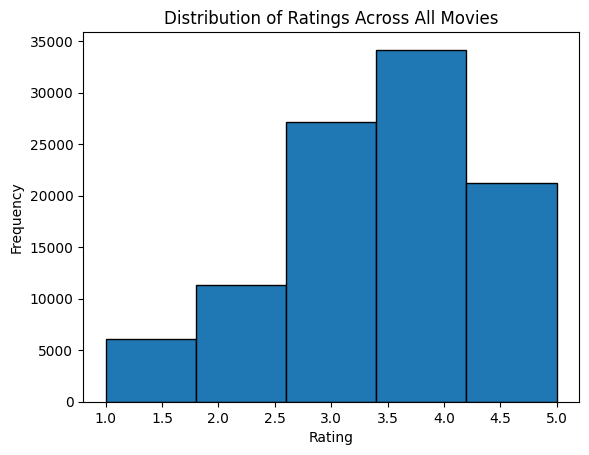

In [41]:
import matplotlib.pyplot as plt

# Plotting the distribution of ratings
user_ratings['rating'].hist(bins=5, grid=False, edgecolor='black')
plt.title('Distribution of Ratings Across All Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

This histogram shows a right-skewed distribution, indicating that lower ratings (1.0 to 2.5) are less frequent than higher ratings (3.0 to 5.0). It suggests that users tend to give movies a rating above the median value, with very few ratings at the lowest end of the scale.

P.S. In my view, the histogram depicting the distribution of ratings across all movies aligns with expected patterns of viewer behavior. The skew towards higher ratings reflects a typical tendency for individuals to choose films that align with their preferences, which naturally leads to a greater number of positive ratings. This distribution suggests that there are no unusual patterns or outliers within the data that would indicate irregularities in rating behavior.

#### 3.2. Analyze Ratings in Conjunction with User Demographics
To find patterns or trends in ratings with respect to demographics like age, gender, and occupation.

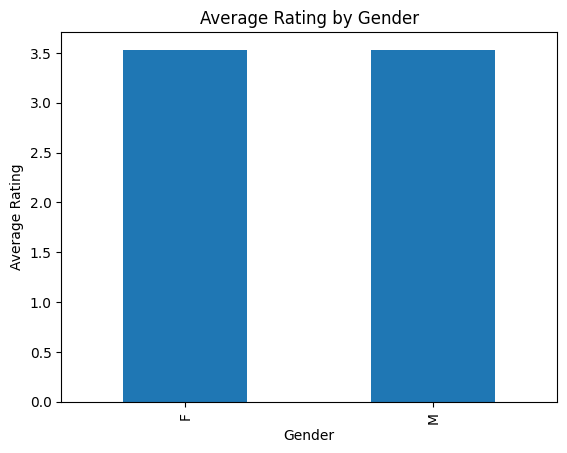

In [42]:
# Merging user_ratings with users to include demographic data
merged_df = pd.merge(user_ratings, users, on='user_id')

# Analyzing rating distribution by gender
merged_df.groupby('gender')['rating'].mean().plot(kind='bar')
plt.title('Average Rating by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Rating')
plt.show()

This bar chart compares the average movie ratings between genders, showing that the averages are very similar. This could imply that movie preferences or rating habits are not significantly different between genders within this dataset.

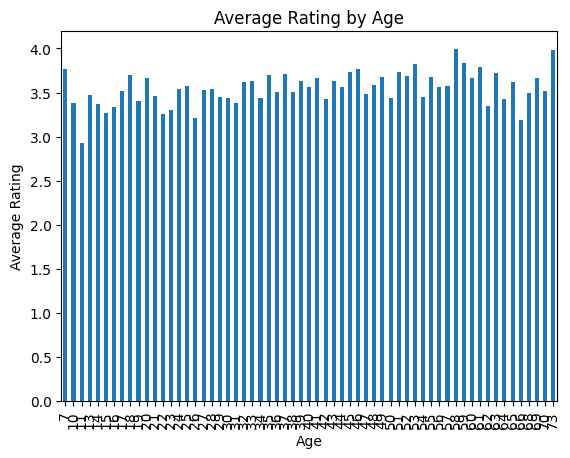

In [43]:
# Analyzing rating distribution by age
merged_df.groupby('age')['rating'].mean().plot(kind='bar')
plt.title('Average Rating by Age')
plt.xlabel('Age')
plt.ylabel('Average Rating')
plt.show()

This bar chart displays average ratings for a range of ages. The ratings appear fairly consistent across different age groups, with slight variations. It suggests that age may not be a strong determinant of how a movie is rated in this particular dataset.

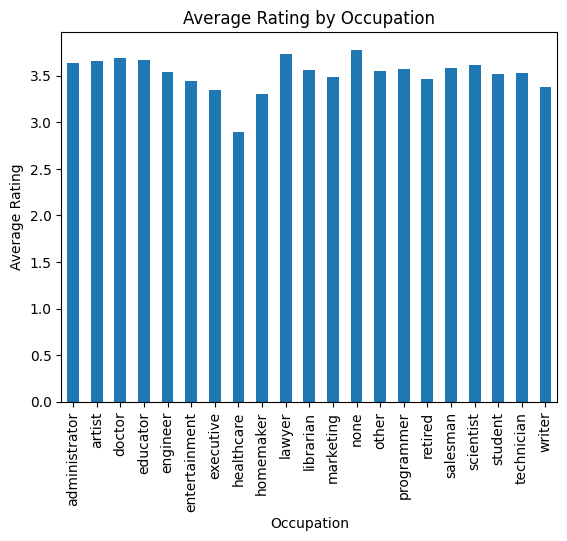

In [44]:
# Analyzing rating distribution by occupation
merged_df.groupby('occupation')['rating'].mean().plot(kind='bar')
plt.title('Average Rating by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.show()

The bar chart indicates that average ratings do not vary widely across different occupations. Most occupation groups seem to rate movies similarly, suggesting that occupation does not heavily influence movie ratings.

#### 3.3. Dependency between Number of Ratings and Average Ratings of Movies
This plot shows whether there's a correlation between the number of ratings a movie receives and its average rating.

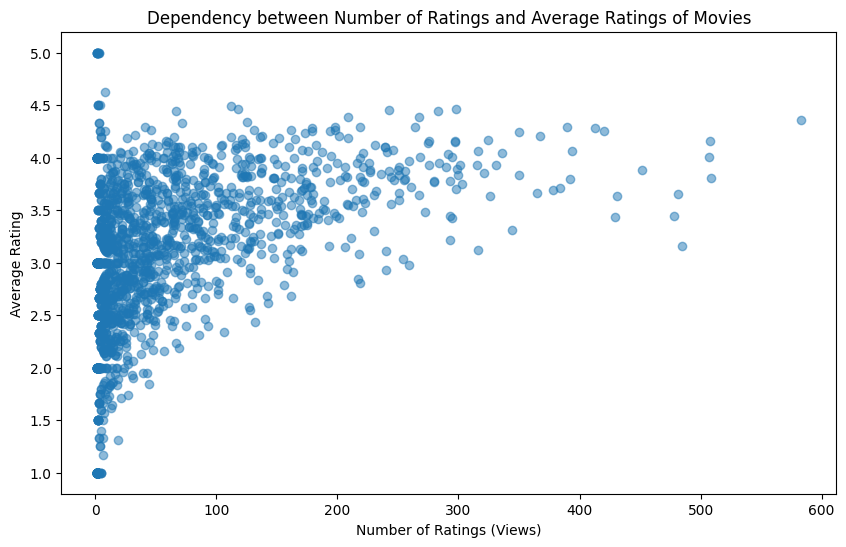

In [45]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(movies['rating_count'], movies['average_rating'], alpha=0.5)
plt.title('Dependency between Number of Ratings and Average Ratings of Movies')
plt.xlabel('Number of Ratings (Views)')
plt.ylabel('Average Rating')
plt.show()

The scatter plot shows a relationship between the number of ratings a movie receives and its average rating. It reveals a trend where movies with more ratings tend to have higher average ratings. This could indicate that more popular or widely watched movies receive better ratings, or that better-rated movies attract more viewers to rate them.

## 4. Conclusion on Data

Overall, the data indicates that within this user base, movie ratings are relatively consistent across different demographics such as gender, age, and occupation. The most notable pattern is that more frequently rated movies tend to have higher average ratings. Rating bias could be handled in model training by using a combination of content-based and collaborative filtering so that the recommendations are not solely based on user-item interactions (ratings) but also on the content (attributes of movies and users).

## 5. Save Data

In [47]:
user_ratings.to_csv('../data/intermediate/filtered_user_ratings.tsv', sep='\t', index=False)
movies.to_csv('../data/intermediate/filtered_movies.tsv', sep='\t', index=False)
users.to_csv('../data/intermediate/filtered_users.tsv', sep='\t', index=False)
